In [ ]:

import Thymio as th
import time
import videopath1 as vp
import numpy as np
import threading
import vision.detect_aruco as da
import cv2
import json

def query_vars(thymio:th.Thymio):
    while True :
        thymio.wait_for_variables()
        
print("Open thymio")
thymio = th.Thymio()
await thymio.initiateLock()
print("Thymio opened")

cap = cv2.VideoCapture(1)

print("Open camera")
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)  # Set the width
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)  # Set the height
print("Camera opened")
detected = False

with open('./vision/camera_calibration.json', 'r') as file:
        params = json.load(file)
    
   
    
        
        
        

Open thymio
Thymio opened
Open camera


In [ ]:
def draw_path(img, path):
   
    for i in range(len(path)-1):
        print(path[i])
        print(path[i][0])
        cv2.line(img, (int(path[i][0]),int(path[i][1])), (int(path[i+1][0]),int(path[i+1][1])), (0, 255, 0), 2)
    return img
        

start: (165.71034240722656, 209.3925018310547, 0.35470565201094034)5470565201094034, scaled :(165.71034240722656, 209.3925018310547, 0.35470565201094034) 
first pos queried (165.71034240722656, 209.3925018310547, 0.35470565201094034)
gray shape: (720, 1280), dims: (685, 1595), cm_per_pixel: 0.10987413194444444
 cm_per_pixel: 0.10987413194444444, cm_per_pixel_height: 0.09513888888888888, cm_per_pixel_width: 0.124609375
Click to select the goal point.
Goal point selected at: (1138, 532)
real and grid start: (165.71034240722656, 209.3925018310547, 0.35470565201094034) (12.0, 8.0)
start: (12.0, 8.0), goal: (29, 71)
neighbor: (11, 8), tentative_g_cost: 1
neighbor: (11, 8), tentative_g_cost: 1
neighbor: (13, 8), tentative_g_cost: 1
neighbor: (13, 8), tentative_g_cost: 1
neighbor: (12, 7), tentative_g_cost: 1
neighbor: (12, 7), tentative_g_cost: 1
neighbor: (12, 9), tentative_g_cost: 1
neighbor: (12, 9), tentative_g_cost: 1
neighbor: (11, 9), tentative_g_cost: 2
neighbor: (11, 9), tentative_g

AxisError: axis 1 is out of bounds for array of dimension 1

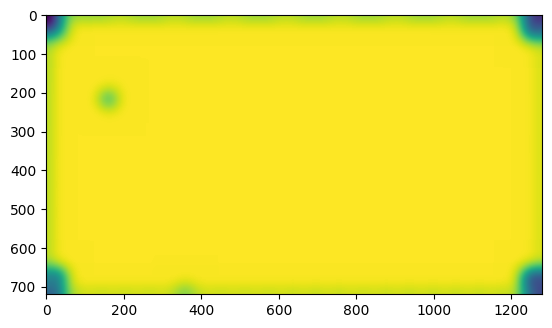

In [ ]:




query = da.main(params, cap)



camera_on = query[0]
original_image = query[1]
display_image = query[2]

start = query[3]
print(f"start: {start}")
cv2.imshow("mainframe", display_image)
cv2.waitKey(1)

while not camera_on or start == (0,0,0):
    
    query = da.main(params, cap)
    camera_on = query[0]
    original_image = query[1]
    display_image = query[2]
    start = query[3]
    cv2.imshow("mainframe", display_image)
    cv2.waitKey(1)
    print("waiting for camera", end="\r")


print("first pos queried",start)
path_cm, _, costmap, block_height, block_width, start, goal, display_image, cm_per_pixel =vp.init(original_image,start)
#cv2.imshow("Select Goal", original_image)
#cv2.setMouseCallback("Select Goal", vp.select_points, original_image)
#path = vp.update(costmap,block_height,block_width,start,vp.points[0],original_image,cm_p_pixel,[])
next_goal = path_cm[0]
current_pos = np.array([start[0],start[1],start[2]])
current_speed = np.array([0,0,0])
camera_position = start
z_predicted = np.concatenate([current_pos,current_speed]) #kalman_state
sigma_predicted = np.diag([0.1,0.1,0.1,0,0,0])

z_list = []

vars_towait = ['prox.horizontal','motor.right.speed','motor.left.speed','motor.right.target','motor.right.target']
#vars_thread = threading.Thread(target=query_vars, args=(stop,thymio), daemon=True)
#vars_thread.start()
time.sleep(1)
thetas = (0.0,0.0)
targets = (0.0,0.0)
while True:
    
    
   
    thymio.wait_for_variables(vars_towait)
    query = da.main(params, cap)
    camera_on = query[0]
    #original_image = query[1]
    display_image = query[2]
    camera_position = query[3]

    #draw_path(display_image, path_cm)
    cv2.putText(display_image, f"X: {z_predicted[0]:.2f} Y: {z_predicted[1]:.2f} Theta: {z_predicted[2]:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(display_image, f"maxmin theta {int(thetas[0]), int(thetas[1])}, targets:{int(targets[0]), int(targets[1])}", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    #draw the grid on the image
    
    #for i in range(0,display_image.shape[1],int(cm_per_pixel)):
    #    cv2.line(display_image, (i,0), (i,display_image.shape[0]), (255, 0, 0), 1)
    #for i in range(0,display_image.shape[0],int(cm_per_pixel)):
    #    cv2.line(display_image, (0,i), (display_image.shape[1],i), (255, 0, 0), 1)
        

    
    print(path_cm, end="\r")
    next_goal = path_cm[0]
    draw_path(display_image, path_cm)
    cv2.circle(display_image, (int(next_goal[0]),int(next_goal[1])), 8, (0, 0, 255), -1)
    print(f'Next goal : {next_goal}')
    print(f'Current position : {current_pos}')
    if not detected:
        translation_or_rotation, thetas, targets = thymio.navigate(current_pos, next_goal)
    current_pos = z_predicted[:3] # Is used for the controller
    print(f"Current position: {current_pos}", end="\r")
    speedright = thymio.getSpeedR()
    speedleft = thymio.getSpeedL()
    
    
    
    z_filtered, sigma_filtered= thymio.filtering_step(z_k_k_1 = z_predicted, 
                                    sigma_k_k_1 = sigma_predicted, 
                                    V_left_measure =speedleft, 
                                    V_right_measure = speedright, 
                                    camera_working=camera_on, 
                                    x_measured=camera_position[0], 
                                    y_measured=camera_position[1],
                                    theta_measured= camera_position[2],
                                    translation_or_rotation = translation_or_rotation)
    
    z_list.append((z_filtered,camera_position,speedleft,speedright))
    
    
    z_predicted, sigma_predicted = thymio.prediction_step(z_filtered, sigma_filtered,translation_or_rotation = translation_or_rotation,camera_working=camera_on)
    if detected:
        thymio.set_multiple_variables({"motor.left.target":[0],"motor.right.target":[0]})
        original_image = query[1]
        path_cm,costmap = vp.update(costmap,block_height,block_width,current_pos,goal,original_image,cm_per_pixel,obstacle,last_pos)
    
    # put the zpredicted on the image
    
    obstacle,detected = thymio.getObstaclePosition()
    if detected:
        print("Obstacle detected")
        last_pos = z_predicted[:3]
        #TODO: use the obstacle position to update the costmap
        thymio.set_multiple_variables({"motor.left.target":[-100],"motor.right.target":[-100]})
        time.sleep(3)
        
    cv2.putText(display_image, f"measured theta: {camera_position[2]}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("mainframe", display_image)
    
    if thymio.robot_close_waypoint(current_pos[:2], next_goal[0], next_goal[1]) or cv2.waitKey(1) & 0xFF == ord('q'):
        path_cm = path_cm[1:]
        if len(path_cm) == 0:
            
            thymio.set_multiple_variables({"motor.left.target":[0],"motor.right.target":[0]})
            #vars_thread.join()
            thymio.stop()
        
            break
    
        
        

In [ ]:
thymio.set_multiple_variables({"motor.left.target":[0],"motor.right.target":[0]})
print(z_list[1])
cv2.destroyAllWindows()
# zlist is a list of tuples (nparray,nparray,speedright,speedleft)
# I want the 2nd nparray of each tuple and the 3rd and 4th element of the tuple
new_array = [ [x[0][2],x[1][0],x[1][1],x[1][2],x[2],x[3]] for x in z_list]

new_array = np.array(new_array)
import matplotlib.pyplot as plt
#print(z_list.shape)



{'motor.left.target': [0], 'motor.right.target': [0]}
(array([ 3.37640411e+02,  2.77775793e+02,  4.13641268e-01, -2.10490161e+00,
       -9.02100689e-01, -1.33571142e-02]), (337.5673522949219, 277.71502685546875, 0.4182243295792291), -5.31886, -3.8413988888888886)


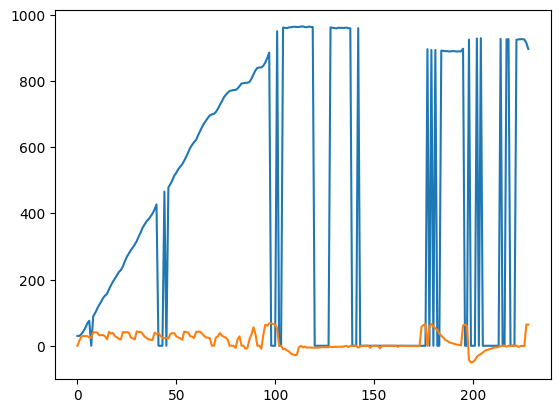

In [ ]:

plt.plot(new_array[:,1],)
plt.plot(new_array[:,4],)